# 1. COMUNICACION DE RESULTADOS

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


#Automcompletar rápido
%config IPCompleter.greedy=True

#Formato de display
pd.options.display.float_format = '{:15.2f}'.format

#Formato de graficos
sns.set_style('darkgrid')

In [70]:
df = pd.read_pickle('Datos/df.pickle')
df_dia = pd.read_pickle('Datos/df_dia.pickle')

## 1.2. CONTEXTO DEL ANALISIS

En este caso trabajamos para una compañía de generación de energía solar fotovoltaica.

Han detectado comportamientos anómalos en 2 de las plantas y la subcontrata de mantenimiento no es capaz de identificar el motivo.

Antes de desplazar a un equipo de ingenieros nos piden al equipo de data science que analicemos los datos de los sensores y medidores para ver si podemos detectar el problema.

Las palancas que influyen sobre el objetivo de negocio (en este caso generar corriente AC) son:

* **Irradiación:** a mayor irradiación mayor DC generada. Pero no es monotónica, a partir de ciertos valores mayor temperatura puede mermar la capacidad de generación
* **Estado de los paneles:** deben estar limpios y con un correcto funcionamiento para generar la mayor energía DC posible
* **Eficiencia de los inverters:** siempre hay una pérdida en la transformación de DC a AC, pero debe ser la mínima posible. También deben estar en correcto estado y funcionamiento.
* **Medidores y sensores:** si se estropean y no miden bien perdemos la trazabilidad y la posibilidad de detectar fallos

Los KPIs son:
* **Irradiación:** mide la energía solar que llega
* **Temperatura ambiente y del módulo:** medida por los sensores de la planta en grados Celsius
* **Potencia DC:** medida los kw de corriente contínua
* **Potencia AC:** medida los kw de corriente alterna

## 1.3. OBJETIVO

Analizar los datos disponibles para intentar intuir donde pueden estar los problemas y si es necesario desplazar o no a un equipo de ingenieros a las plantas.

## 1.4. CONCLUSIONES EJECUTIVAS

Tras un ananálisis de los datos podemos concluir que:

* Existen graves problemas de calidad de datos. Se debería revisar en qué parte de la cadena se generan estos problemas, incluyendo los medidores de las plantas.
* El hecho de que la generación en DC sea unas 10 veces superior en la planta 1 que en la 2, sumado al hecho de que la eficiencia en la planta 1 esté sobre el 10% nos lleva a pensar que el dato de generación de DC en la planta 1 puede estar artificialmente escalado por algún motivo. Pero de momento a falta de comprobación vamos a asumir que los datos son correctos.
* La dos plantas han recibido altas cantidades de irradiación, no hemos localizado ningún problema en esta fase
* Aunque la temperatura ambiente es superior en la planta 2 y sus módulos se calientan más que los de la planta 1 esto no parece tener un impacto significativo
* La generación de DC de la planta 1 funciona bien, los módulos parecen llevar DC a los inverters.
* La generación de DC de la planta 2 NO funciona bien, algunos módulos llevan muy poco DC a los inverters incluso en las horas de mayor irradiación.
* La transformación de DC a AC de la planta 1 NO funciona bien, solo se transforma en torno al 10%, eso sí, de forma constante. Y esta baja eficiencia no es debida a momentos de no recepción de DC ni se concentra en inverters concretos, si no que parece más estructural (de nuevo tener en cuenta que podría deberse a un problema de calidad de datos en kw_dc de la planta 1
* La transformación de DC a AC de la planta 2 funciona bien, ya que una vez eliminados los períodos de generación cero de DC el resto tienen una eficiencia superior al 97%
  
Recomendaciones:

* Revisar la captación de datos y su fiabilidad
* Revisión de mantenimiento en los módulos de los inverters de la planta 2 en los que hay muchos momentos de generación cero de DC
* Revisión de mantenimiento de los inverters de la Planta 1

## 1.5. DETALLE DE LOS PRINCIPALES RESULTADOS

### 1.5.1. Las dos plantas reciben altas y similares cantidades de irradiación, sin muestra de que haya ningún problema en este punto

* En general la planta 2 recibe más energía solar que la 1
* Pero esta diferencia no puede implicar el problema de rendimiento que supuestamente existe

Exhibit 1.5.1

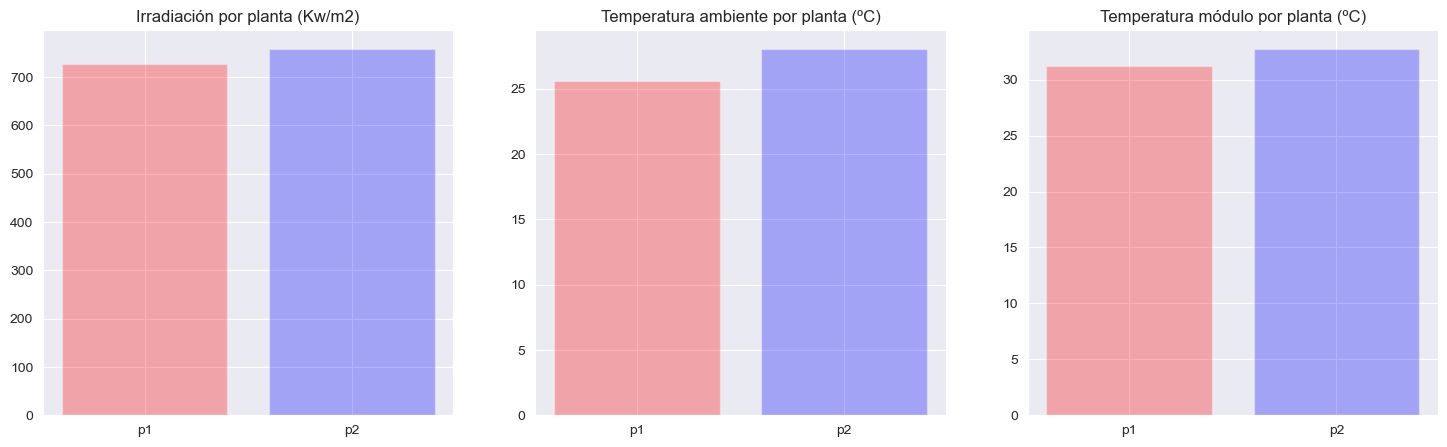

In [19]:
recepcion = df.loc[(df.inverter_id == '1BY6WEcLGh8j5v7') | (df.inverter_id == 'q49J1IKaHRwDQnt'), 'planta':'t_modulo']
temp = recepcion.groupby('planta').agg({'irradiacion':'sum', 't_ambiente':'mean', 't_modulo':'mean'})

f, ax = plt.subplots(nrows=1, ncols=3, figsize = (18,5))

ax[0].bar(temp.index, temp.irradiacion, color = ['red','blue'], alpha = 0.3)
ax[1].bar(temp.index, temp.t_ambiente, color = ['red','blue'], alpha = 0.3)
ax[2].bar(temp.index, temp.t_modulo, color = ['red','blue'], alpha = 0.3)
ax[0].set_title('Irradiación por planta (Kw/m2)')
ax[1].set_title('Temperatura ambiente por planta (ºC)')
ax[2].set_title('Temperatura módulo por planta (ºC)');

### 1.5.2. Existe irradiación entre las 7 y las 17 horas, la irradiación máxima se produce entre las 11 y 12 horas

* Ambas plantas tienen patrones similares. Podríamos pensar que están en zonas geográficas no muy alejadas
* Existe irradiación entre las 7 y las 17
* La irradiación máxima se produce entre las 11 y las 12

Exhibit 1.5.2

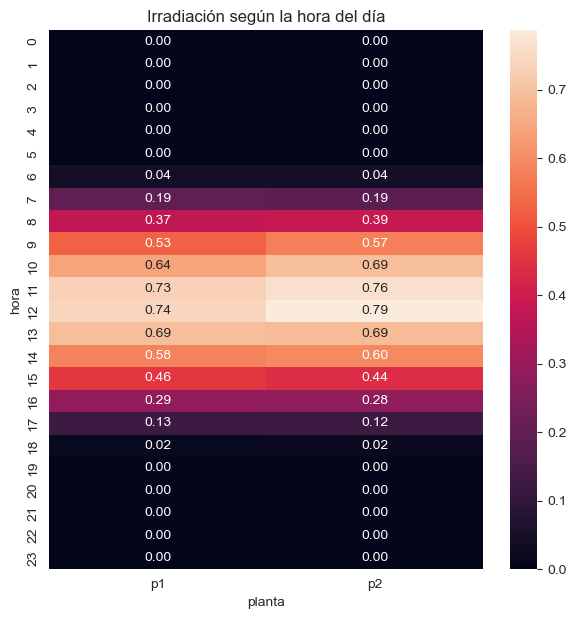

In [72]:
temp = pd.crosstab(recepcion.hora,recepcion.planta,values = recepcion.irradiacion,aggfunc='mean')
plt.figure(figsize=(7,7))
sns.heatmap(temp,annot=True, fmt=".2f");
plt.title('Irradiación según la hora del día');

### 1.5.3. La planta 2 genera niveles mucho más bajos de DC incluso a niveles similares de irradiación

* El hecho de que la generación en DC sea unas 10 veces superior en la planta 1 que en la 2, sumado al hecho de que la eficiencia en la planta 1 esté sobre el 10% nos lleva a pensar que el dato de generación de DC en la planta 1 puede estar artificialmente escalado por algún motivo. Pero de momento a falta de comprobación vamos a asumir que los datos son correctos.
* La generación de DC de la planta 1 es correcta, los módulos parecen llevar DC a los inverters
* La generación de DC de la planta 2 NO funciona bien, los módulos llevan muy poco DC a los inverters incluso en las horas de mayor irradiación

Exhibit 1.5.3

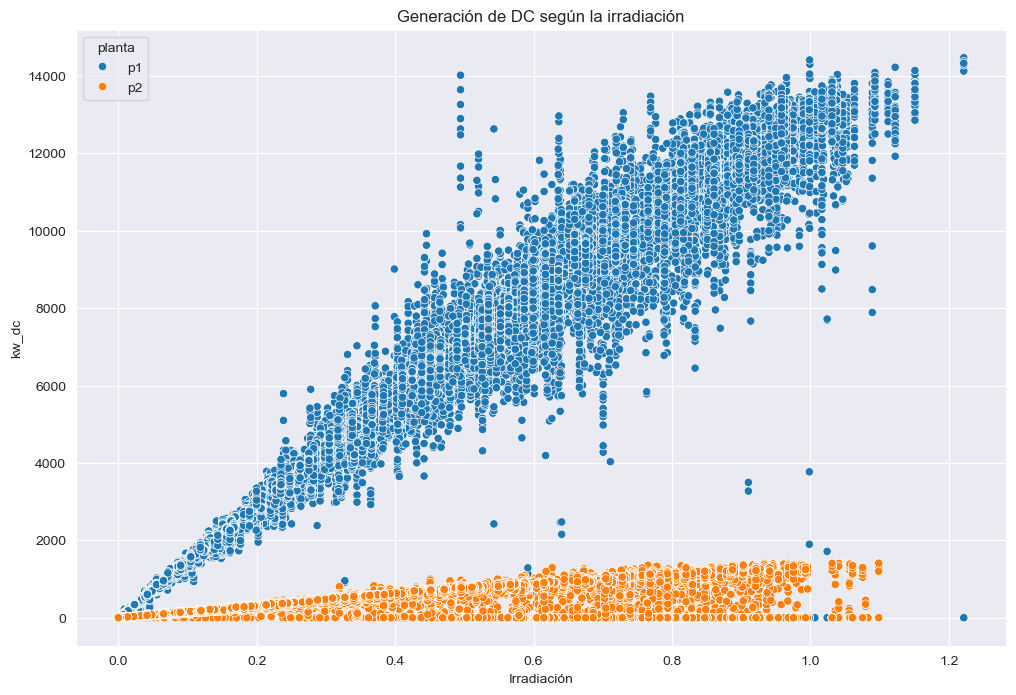

In [74]:
plt.figure(figsize = (12,8))
sns.scatterplot(data = df, x = df.irradiacion, y = df.kw_dc, hue = 'planta')
plt.xlabel('Irradiación')
plt.title('Generación de DC según la irradiación');

### 1.5.4. La transformación de DC a AC de la planta 1 NO funciona bien, solo se transforma en torno al 10%, eso sí, de forma constante.

Esta baja eficiencia no es debida a momentos de no recepción de DC ni se concentra en inverters concretos, si no que parece más estructural.

Exhibit 1.5.4

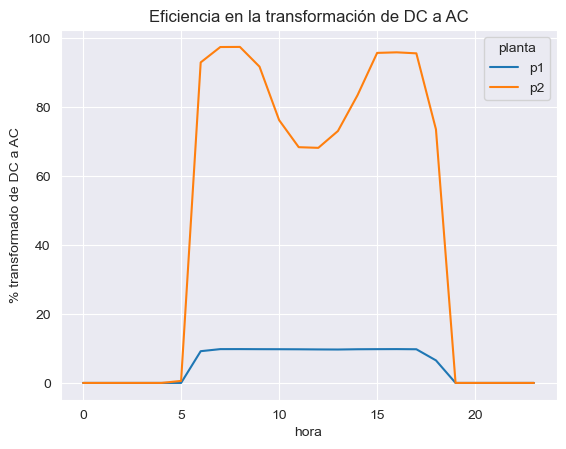

In [76]:
temp = df.groupby(['planta','hora'],as_index = False).eficiencia.mean()
sns.lineplot(data = temp, x = 'hora', y = 'eficiencia', hue = 'planta')
plt.ylabel('% transformado de DC a AC')
plt.title('Eficiencia en la transformación de DC a AC');

### 1.5.5. La transformación de DC a AC de la planta 2 funciona bien, ya que una vez eliminados los períodos de generación cero de DC el resto tienen una eficiencia superior al 97%

En la planta 2 existen varios inverters a los que no está llegando suficiente producción de DC, y por tanto cuyos módulos necesitan revisión.
Una vez descontando el problema de la no generación de DC, los inverters de la planta 2 sí funcionan bien y hacen bien el trabajo de transformación a AC.

Exhibit 1.5.5

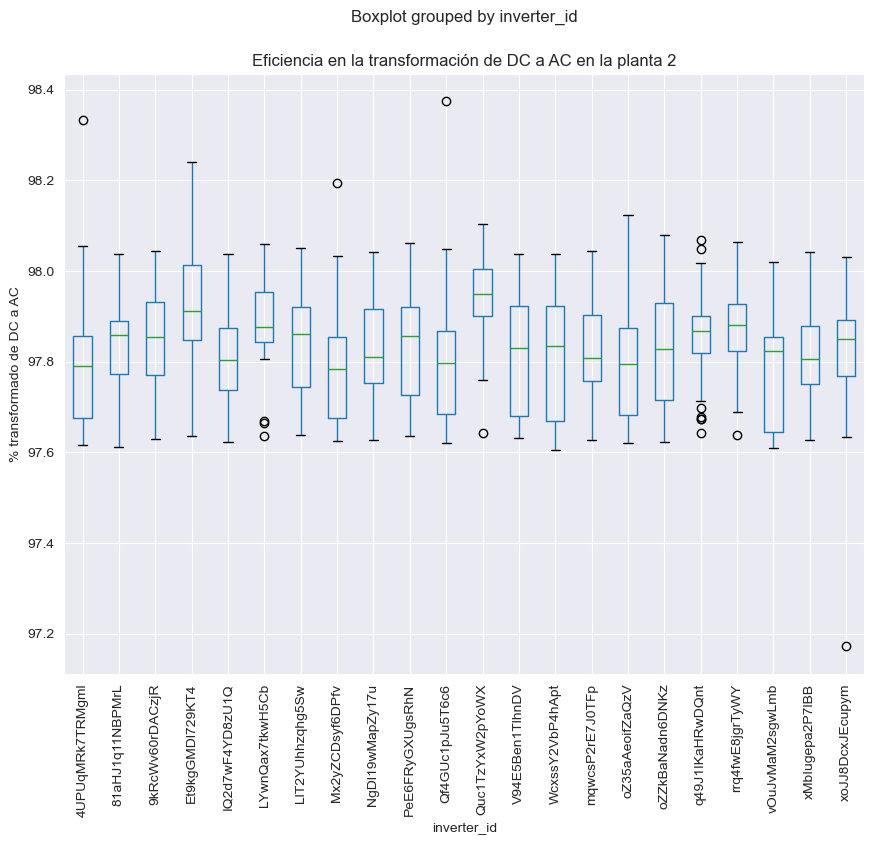

In [77]:
df['date'] = df.index.date
temp = df.between_time('08:00:00','15:00:00')
temp = temp[temp.planta == 'p2']
temp[temp.kw_dc > 0].groupby(['inverter_id','date'],as_index = False).eficiencia.mean().boxplot(column = 'eficiencia', by = 'inverter_id', figsize = (10,8))
plt.xticks(rotation = 90)
plt.ylabel('% transformado de DC a AC')
plt.title('Eficiencia en la transformación de DC a AC en la planta 2');